# ECE 535/435 Lab 5: MMSE Estimation and Least Squares

### Name: Amir Reza Vazifeh

### Import Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time


%matplotlib inline

### Load Data

For the training data, the first 1000 columns are the digit of 0, the next 1000 columns are the digit of 1, and so on, up to digit 9. For the testing data, the first 100 columns are the digit of 0, the next 100 columns are the digit of 1, and so on, up to digit 9.

In [2]:
# Load MNIST train and test data
# Normalize image pixels to [0,1]

train = np.load('/content/sample_data/MNISTcwtrain1000.npy').astype(float)/255
test = np.load('/content/sample_data/MNISTcwtest100.npy').astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print('-----MNIST Dataset Loaded-----')
print('Train Data: %d x %d' %(size,n_train))
print('Test Data: %d x %d' %(size,n_test))

-----MNIST Dataset Loaded-----
Train Data: 784 x 10000
Test Data: 784 x 1000


In [3]:
# This function will return the indices of the pixels in
# a centered square of side length: d = 2, 4, 6, 8,..., 12, 14.
# It is provided.

def return_mask_idx(sl):
    s = 14-sl//2
    idx = []
    for i in range(sl):
        for j in range(sl):
            idx.append(28*(s+i)+s+j)
    return idx

### 1. Mask Center Square of MNIST Digits
a) Implement a function to fill an dxd square in the image center with black (this is done for you).

In [4]:
#This function is provided

def hide(img_vector, mask_idx):
    img_vector_copy = np.copy(img_vector)
    img_vector_copy[mask_idx] = 0
    return img_vector_copy

b) Using $d = 12$, display the original image and the corresponding masked image, in a 1 by 2 array, for the first example in each class of the testing data.

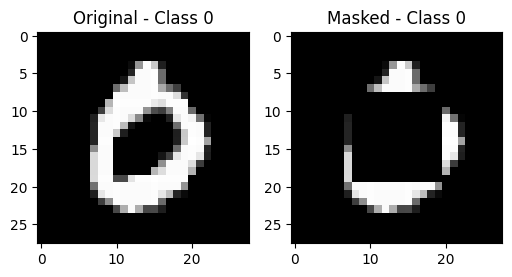

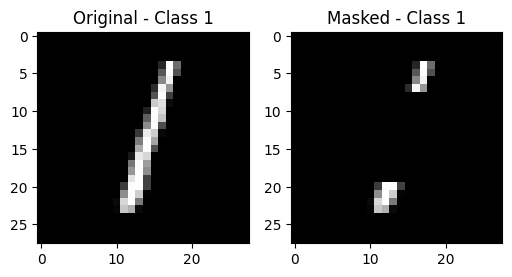

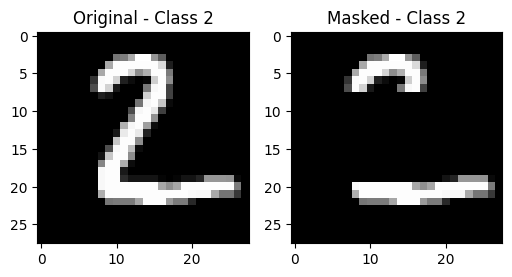

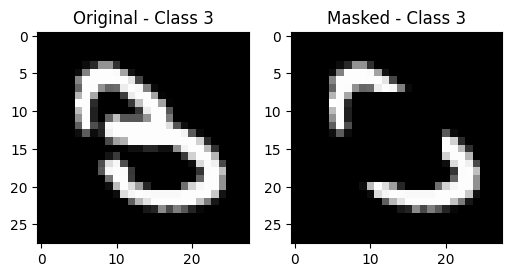

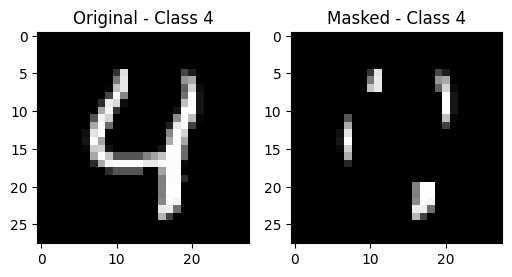

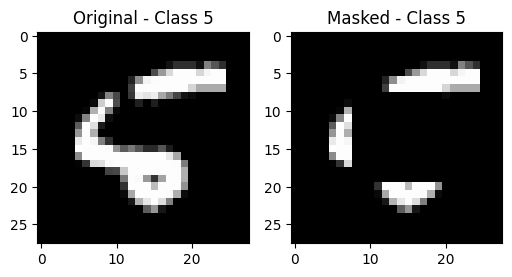

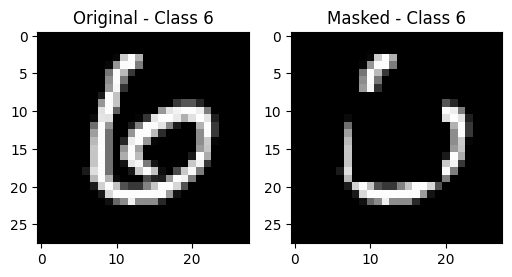

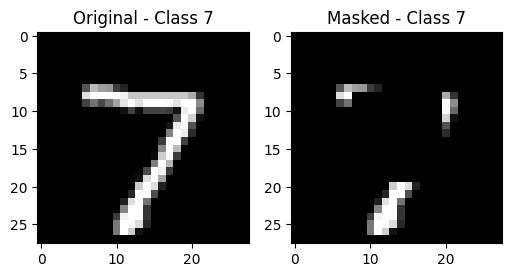

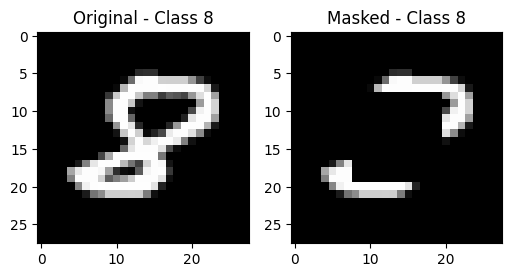

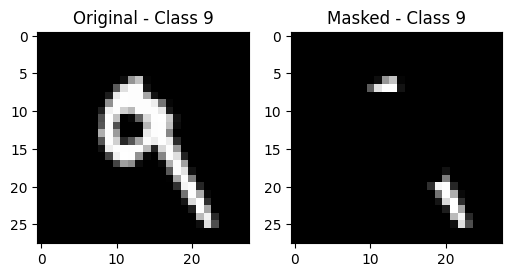

In [5]:
"Display original and masked images"

# Set the desired side length 'd' (12 in this case)
d = 12
hidden_idx = return_mask_idx(d)
remain_idx = np.delete(np.arange(0, 784), hidden_idx)

for class_label in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:

  # Find the first example in the testing data for the current class
  original_image = test[:, class_label]

  # Hide the image using 'hide' function
  masked_image = hide(original_image, hidden_idx)

  # Plotting
  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 1)
  plt.title(f'Original - Class {int(class_label/100)}')
  plt.imshow((original_image.reshape(28, 28)).T, cmap='gray')
  plt.subplot(1, 2, 2)
  plt.title(f'Masked - Class {int(class_label/100)}')
  plt.imshow((masked_image.reshape(28, 28)).T, cmap='gray')
  plt.show()

c) Now use the training data to estimate the MMSE affine estimator $(W, b)$ of the masked pixel values based on the unmasked pixel values. Write this so that you can use any vlaue of $d$.

Solution: Consider a training dataset ${\{(x_i, y_i)\}^{m}_{i=1}}$,
with examples $x_i \in \mathbb{R}^n$ and targets $y_i \in \mathbb{R}^q$. Let $X$ denote the matrix with the examples as its columns, and $Y$ denote the matrix with the corresponding targets as its columns. Define the following first and second-order empirical statistics of the data:

$\mu_X = \frac{1}{m} \hspace{1mm} X \hspace{1.5mm} \boldsymbol{1_m}$

$\mu_Y = \frac{1}{m} \hspace{1mm} Y \hspace{1.5mm} \boldsymbol{1_m}$

$\Sigma_X = \frac{1}{m} (X − \mu_X \hspace{0.5mm} \boldsymbol{1_m}^T) \hspace{0.5mm} (X − \mu_X \hspace{0.5mm} \boldsymbol{1_m}^T)^T$

$\Sigma_{XY} = \frac{1}{m} (X − \mu_X \hspace{0.5mm} \boldsymbol{1_m}^T) \hspace{0.5mm} (Y − \mu_Y \hspace{0.5mm} \boldsymbol{1_m}^T)^T$

A MMSE affine estimator $ \hat{y} = w^Tx + b$ based on the empirical statistics (4.33) must satisfy:

$\Sigma_X W =  \Sigma_{XY}$

$b = \mu_Y - W^{T}\mu_X$


In [6]:
def MMSE_affine_estimator(Input_data, d_size):

  """ Get the MMSE estimator parameters (W, b) for a given d.

  Parameters:
  d_size (int): Size of the square mask.
  Input_data: Training data (2D array of images --> number of pixels by number of images)

  Returns:
  W (array-like): Weight matrix for the estimator.
  b (array-like): Bias vector for the estimator. """


  # Identifying modified (hidden pixels) and unchanged pixel indices
  hidden_index = return_mask_idx(d_size)
  remain_index = np.delete(np.arange(0, np.shape(Input_data)[0]), hidden_index)

  # Pixel values of hidden and unchnaged regions
  X_Train = Input_data[remain_index, :]
  Y_Train = Input_data[hidden_index, :]

  # Making vetor one with size m
  m = np.shape(X_Train)[1]
  one_vec = np.ones(m)

  # Finding first and second-order empirical statistics of the data
  mu_X = 1/m * X_Train @ one_vec
  mu_Y = 1/m * Y_Train @ one_vec
  cov_X = 1/m * (X_Train - np.column_stack([mu_X] * m)) @ (X_Train - np.column_stack([mu_X] * m)).T
  cov_XY = 1/m * (X_Train - np.column_stack([mu_X] * m)) @ (Y_Train - np.column_stack([mu_Y] * m)).T

  # Finding weight matrix and bias vector of the estimator
  W = np.linalg.pinv(cov_X) @ cov_XY
  b = mu_Y - W.T @ mu_X

  return W, b

In [7]:
# Set the desired side length 'd' (12 in this case)
d = 12

# Applying MMSE_affine_estimator on training data to find W and b
W_estimated, b_estimated = MMSE_affine_estimator(train, d)

# Apply the weights on testing data to reconstruct images
hidden_idx = return_mask_idx(d)
remain_idx = np.delete(np.arange(0, np.shape(train)[0]), hidden_idx)
X_test = test[remain_idx, :]
Y_hat_test = W_estimated.T @ X_test + np.column_stack([b_estimated] * n_test)

# Reconstructing images
reconstructed_test = np.zeros(np.shape(test))
reconstructed_test[remain_idx, :] = X_test
reconstructed_test[hidden_idx, :] = Y_hat_test

d) Now modify you code for part b) to display the original image, the corresponding masked image, and the estimated image in a 1 by 3 array, for the first example in each class of the testing data.

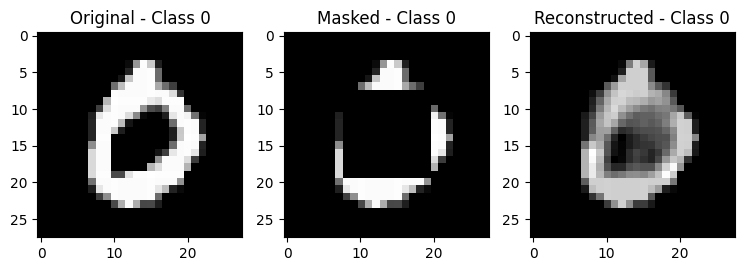

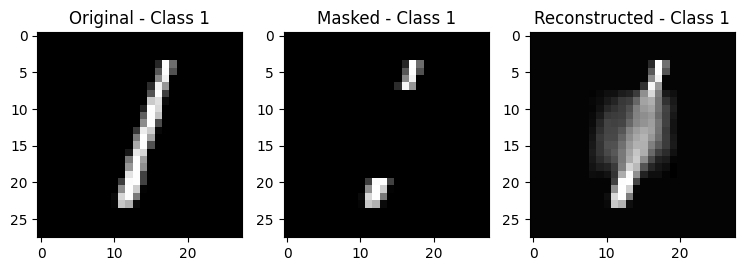

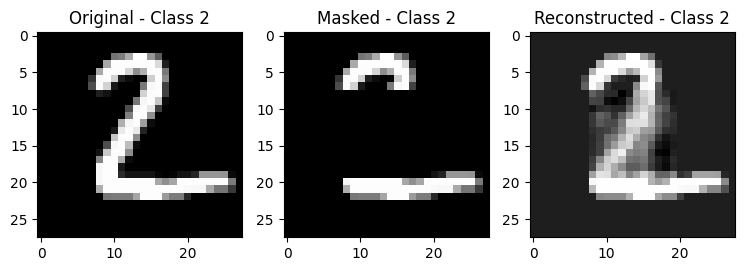

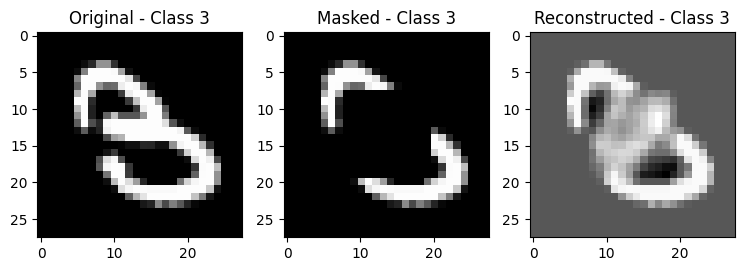

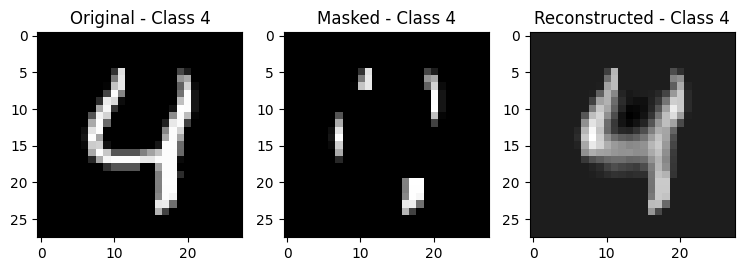

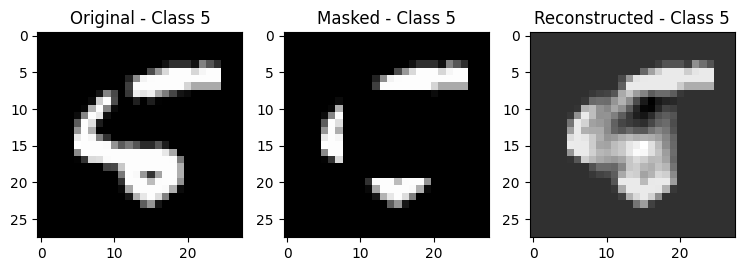

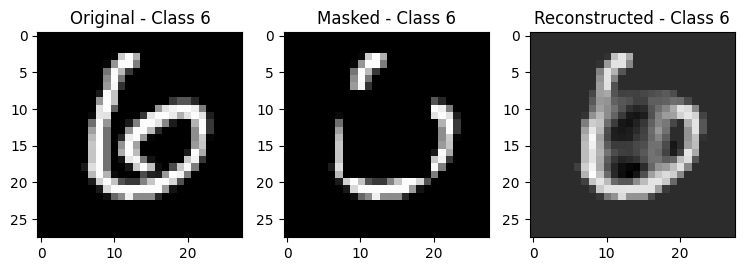

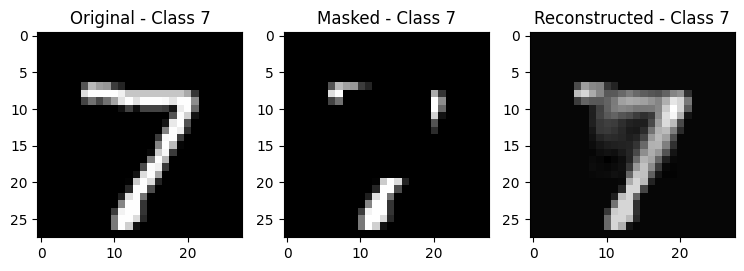

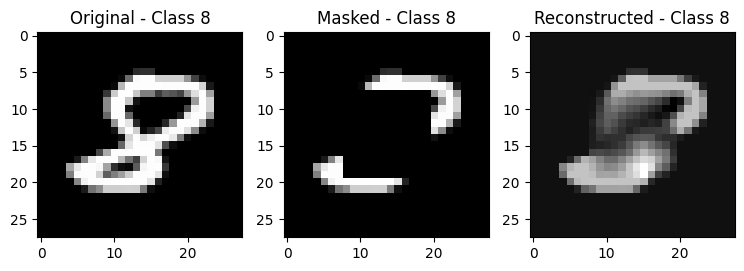

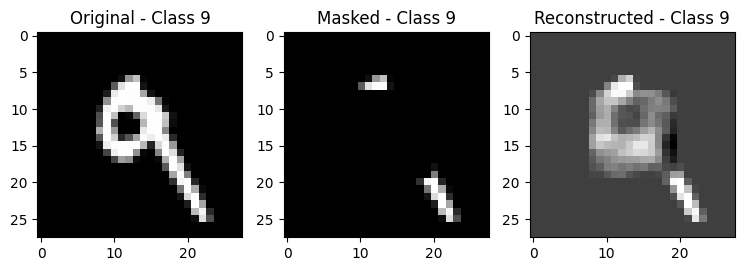

In [8]:
"# Display original, masked, and estimated testing images"

# Set the desired side length 'd' (12 in this case)
d = 12
hidden_idx = return_mask_idx(d)
remain_idx = np.delete(np.arange(0, 784), hidden_idx)

for class_label in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:

  # Find the first example in the testing data for the current class
  original_image = test[:, class_label]

  # Hide the image using 'hide' function
  masked_image = hide(original_image, hidden_idx)

  # Reconstructing first sample of each class in test data
  reconstructed_image = reconstructed_test[:, class_label]

  # Plotting
  plt.figure(figsize=(9, 3))
  plt.subplot(1, 3, 1)
  plt.title(f'Original - Class {int(class_label/100)}')
  plt.imshow((original_image.reshape(28, 28)).T, cmap='gray')
  plt.subplot(1, 3, 2)
  plt.title(f'Masked - Class {int(class_label/100)}')
  plt.imshow((masked_image.reshape(28, 28)).T, cmap='gray')
  plt.subplot(1, 3, 3)
  plt.title(f'Reconstructed - Class {int(class_label/100)}')
  plt.imshow((reconstructed_image.reshape(28, 28)).T, cmap='gray')
  plt.show()

### 2. Classify the Images using the nearest mean classifier.

The nearest mean classifier uses the image labels (0,...,9) to compute the mean image of each class ($\mu_0$, $\mu_1$, ...,$\mu_9$). Then classifies a new example to be the label of the nearest class mean.  
$$ \hat y (x) = \arg\min_{i\in [0,9]} \|x- \mu_i\|^2 $$  

(a) Compute the class means using the unmasked training images.   


In [9]:
'''Use the training data to compute the class means'''

# Split the data into class-wise groups
class_data = []
for i in range(10):
    class_data.append(train[:, i*1000:(i+1)*1000])

# Calculate the mean image of each class
class_means = [np.mean(classs, axis=1) for classs in class_data]


(b) Classify the training images using the nearest mean classifer. Record the accuracy.  


In [10]:
'''Define nearest mean classifier'''

# Function to classify a new example to the nearest class mean
def classify_to_nearest_class(example, class_mean):
    distances = [np.linalg.norm(example - mean_img) for mean_img in class_mean]
    return np.argmin(distances)

In [11]:
'''First: Classify the training data'''

# Now, you have the mean images for each class. You can use these for classification.
# Example usage of the classification function
predicted_class_train = np.zeros(n_train)
train_true_label = np.zeros(n_train)
error_train_unmasked = 0
for i in range(n_train):
  predicted_class_train[i] = classify_to_nearest_class(train[:, i], class_means)
  train_true_label[i] = i // 1000

  if (predicted_class_train[i] != train_true_label[i]):
    error_train_unmasked += 1

print("Unmasked training image classification using mean classifier: ")
print("Error rate = ", "{:.3f}".format(error_train_unmasked/n_train), "   ", "Accuracy = ", "{:.3f}".format(1-error_train_unmasked/n_train))


Unmasked training image classification using mean classifier: 
Error rate =  0.196     Accuracy =  0.804


(c) Classify the testing images using the nearest mean classifer. Record the accuracy.

In [12]:
'''Second: classify the testing data'''

# Example usage of the classification function
predicted_class_test = np.zeros(1000)
test_true_label = np.zeros(1000)
error_test_unmasked = 0
for i in range(1000):
  predicted_class_test[i] = classify_to_nearest_class(test[:, i], class_means)
  test_true_label[i] = i // 100

  if (predicted_class_test[i] != test_true_label[i]):
    error_test_unmasked += 1

print("Unmasked testing image classification using mean classifier: ")
print("Error rate = ", "{:.3f}".format(error_test_unmasked/n_test), "   ", "Accuracy = ", "{:.3f}".format(1-error_test_unmasked/n_test))

Unmasked testing image classification using mean classifier: 
Error rate =  0.233     Accuracy =  0.767



(d) For $d=2,..., 14$ classify the masked training images and the masked testing images using the nearest mean classifer.

In [13]:
'''Third: Classify the masked training data vs d'''

# For through the desired side length 'd'
accuracy_train = []
error_train_list = []

print("Masked training image classification using mean classifier: ")
for d in [2, 4, 6, 8, 10, 12, 14]:

  hidden_idx = return_mask_idx(d)
  train_hidden = train.copy()
  train_hidden[hidden_idx, :] = 0

  # Example usage of the classification function
  predicted_class_train = np.zeros(n_train)
  train_true_label = np.zeros(n_train)
  error_train_masked = 0
  for i in range(n_train):
    predicted_class_train[i] = classify_to_nearest_class(train_hidden[:, i], class_means)
    train_true_label[i] = i // 1000

    if (predicted_class_train[i] != train_true_label[i]):
      error_train_masked += 1

  accuracy_train.append(1-error_train_masked/n_train)
  error_train_list.append(error_train_masked/n_train)
  print("for d = ", d, ": Error rate = ", "{:.3f}".format(error_train_masked/n_train), "    Accuracy = ", "{:.3f}".format(1-error_train_masked/n_train))

Masked training image classification using mean classifier: 
for d =  2 : Error rate =  0.195     Accuracy =  0.805
for d =  4 : Error rate =  0.217     Accuracy =  0.783
for d =  6 : Error rate =  0.277     Accuracy =  0.723
for d =  8 : Error rate =  0.361     Accuracy =  0.639
for d =  10 : Error rate =  0.468     Accuracy =  0.532
for d =  12 : Error rate =  0.619     Accuracy =  0.381
for d =  14 : Error rate =  0.759     Accuracy =  0.241


In [14]:
'''Fourth: Classify the masked testing data vs d'''

# For through the desired side length 'd'
accuracy_test = []
error_test_list = []
print("Masked testing image classification using mean classifier: ")
for d in [2, 4, 6, 8, 10, 12, 14]:

  hidden_idx = return_mask_idx(d)
  test_hidden = test.copy()
  test_hidden[hidden_idx, :] = 0

  # Example usage of the classification function
  predicted_class_test = np.zeros(n_test)
  test_true_label = np.zeros(n_test)
  error_test_masked = 0
  for i in range(n_test):
    predicted_class_test[i] = classify_to_nearest_class(test_hidden[:, i], class_means)
    test_true_label[i] = i // 100

    if (predicted_class_test[i] != test_true_label[i]):
      error_test_masked += 1

  accuracy_test.append(1-error_test_masked/n_test)
  error_test_list.append(error_test_masked/n_test)
  print("d = ", d, ": Error rate = ", "{:.3f}".format(error_test_masked/n_test), "    Accuracy = ", "{:.3f}".format(1-error_test_masked/n_test))

Masked testing image classification using mean classifier: 
d =  2 : Error rate =  0.225     Accuracy =  0.775
d =  4 : Error rate =  0.245     Accuracy =  0.755
d =  6 : Error rate =  0.294     Accuracy =  0.706
d =  8 : Error rate =  0.368     Accuracy =  0.632
d =  10 : Error rate =  0.478     Accuracy =  0.522
d =  12 : Error rate =  0.660     Accuracy =  0.340
d =  14 : Error rate =  0.779     Accuracy =  0.221


(e) Plot the classification error as a function of $d$. On the plot also indicate the classification error for the unmasked images and chance accuracy. Use a legend to distinguish the lines.

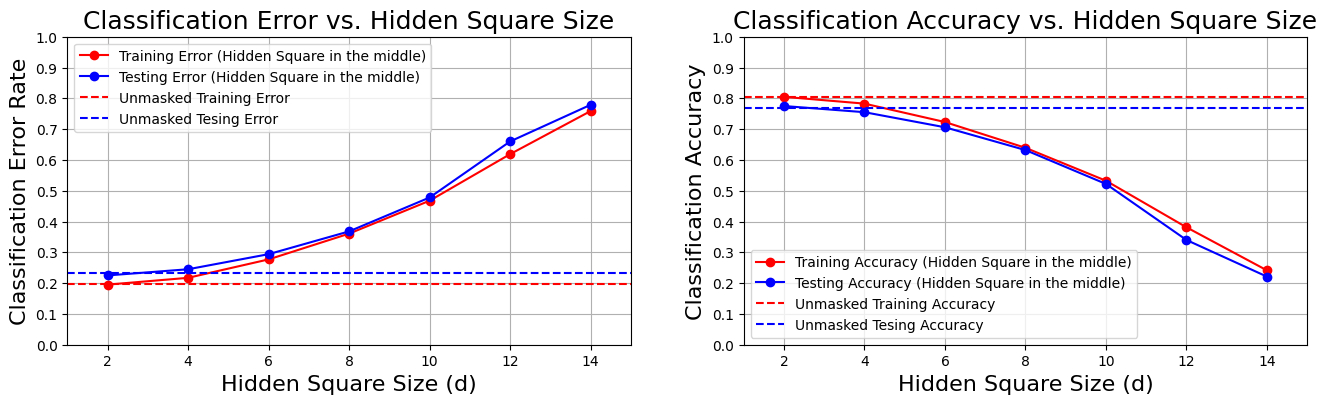

In [16]:
# Now plot the training and testing error vs lambda

d_array = np.array([2, 4, 6, 8, 10, 12, 14])

# Set the figure size width and height
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(d_array, error_train_list, color='red', marker='o', label='Training Error (Hidden Square in the middle)')
axes[0].plot(d_array, error_test_list, color='blue', marker='o', label='Testing Error (Hidden Square in the middle)')
axes[0].axhline(error_train_unmasked/n_train, color='red', linestyle='--', label='Unmasked Training Error')
axes[0].axhline(error_test_unmasked/n_test, color='blue', linestyle='--', label='Unmasked Tesing Error')

# Add labels
axes[0].set_xlabel('Hidden Square Size (d)', fontsize=16)
axes[0].set_ylabel('Classification Error Rate', fontsize=16)
axes[0].set_title('Classification Error vs. Hidden Square Size', fontsize=18)
axes[0].grid()

# Create a list of x-tick positions from 2 to 14 with a step of 2
xtick_positions = range(2, 15, 2)

# Now, set the x-ticks using the created list
axes[0].set_xticks(xtick_positions)

# Set the x-axis limits to 1 and 15
axes[0].set_xlim(1, 15)

# Create a list of y-tick positions from 0 to 1 with a step of 0.1
ytick_positions = np.array([i/10 for i in range(11)])

# Now, set the y-ticks using the created list
axes[0].set_yticks(ytick_positions)

# Add a legend to the plot
axes[0].legend()


axes[1].plot(d_array, accuracy_train, color='red', marker='o', label='Training Accuracy (Hidden Square in the middle)')
axes[1].plot(d_array, accuracy_test, color='blue', marker='o', label='Testing Accuracy (Hidden Square in the middle)')
axes[1].axhline(1-error_train_unmasked/n_train, color='red', linestyle='--', label='Unmasked Training Accuracy')
axes[1].axhline(1-error_test_unmasked/n_test, color='blue', linestyle='--', label='Unmasked Tesing Accuracy')

# Add labels
axes[1].set_xlabel('Hidden Square Size (d)', fontsize=16)
axes[1].set_ylabel('Classification Accuracy', fontsize=16)
axes[1].set_title('Classification Accuracy vs. Hidden Square Size', fontsize=18)
axes[1].grid()

# Now, set the x-ticks using the created list
axes[1].set_xticks(xtick_positions)

# Set the x-axis limits to 1 and 15
axes[1].set_xlim(1, 15)

# Now, set the y-ticks using the created list
axes[1].set_yticks(ytick_positions)

# Add a legend to the plot
axes[1].legend()

# Display the plot
plt.show()

### 3. Use least squares to approximate the masked pixels (estimation of the hidden part of the image)
Calculate the MSE for each example by constructing the following affine MSE estimator.

\begin{equation}
\arg \min_{W\in\mathbb{R}^{d^2 x(784-d^2)}}\|y-Wx-b\|_2^2
\end{equation}
\begin{equation}
y \in \mathbb{R}^{d^2}  \hspace{5mm} b \in \mathbb{R}^{d^2} \hspace{5mm} X \in \mathbb{R}^{(784-d^2)}
\end{equation}

Here $y$ is the vector of masked pixel valaues and $x$ is the remainder of the pixel values.

Then use the NM classifier to classify each reconstructed test image and each reconstructed training image.
Plot the accuracies in each on a copy of the previous plot.

In [17]:
'''Predict of missing pixels on testing data then classify'''

accuracy_reconstructed_test_list = []
error_reconstructed_test_list = []

print("Estimated testing image classification using mean classifier: ")
# For through the desired side length 'd'
for d in [2, 4, 6, 8, 10, 12, 14]:

  # Applying MMSE_affine_estimator on training data to find W and b
  W_estimated, b_estimated = MMSE_affine_estimator(train, d)

  # Apply the weights on testing data to reconstruct images
  hidden_idx = return_mask_idx(d)
  remain_idx = np.delete(np.arange(0, np.shape(train)[0]), hidden_idx)
  X_test = test[remain_idx, :]
  Y_hat_test = W_estimated.T @ X_test + np.column_stack([b_estimated] * n_test)

  # Reconstructing images
  reconstructed_test = np.zeros(np.shape(test))
  reconstructed_test[remain_idx, :] = X_test
  reconstructed_test[hidden_idx, :] = Y_hat_test

  # Example usage of the classification function
  predicted_class_reconstructed_test = np.zeros(n_test)
  test_true_label = np.zeros(n_test)
  error_reconstructed_test = 0
  for i in range(n_test):
    predicted_class_reconstructed_test[i] = classify_to_nearest_class(reconstructed_test[:, i], class_means)
    test_true_label[i] = i // 100

    if (predicted_class_reconstructed_test[i] != test_true_label[i]):
      error_reconstructed_test += 1

  accuracy_reconstructed_test_list.append(1-error_reconstructed_test/n_test)
  error_reconstructed_test_list.append(error_reconstructed_test/n_test)
  print("d = ", d, ": Error rate = ", "{:.3f}".format(error_reconstructed_test/n_test), "    Accuracy = ", "{:.3f}".format(1-error_reconstructed_test/n_test))


Estimated testing image classification using mean classifier: 
d =  2 : Error rate =  0.233     Accuracy =  0.767
d =  4 : Error rate =  0.246     Accuracy =  0.754
d =  6 : Error rate =  0.274     Accuracy =  0.726
d =  8 : Error rate =  0.298     Accuracy =  0.702
d =  10 : Error rate =  0.318     Accuracy =  0.682
d =  12 : Error rate =  0.355     Accuracy =  0.645
d =  14 : Error rate =  0.393     Accuracy =  0.607


In [18]:
'''Predict of missing pixels on training data then classify'''

accuracy_reconstructed_train_list = []
error_reconstructed_train_list = []

print("Estimated training image classification using mean classifier: ")
# For through the desired side length 'd'
for d in [2, 4, 6, 8, 10, 12, 14]:

  # Applying MMSE_affine_estimator on training data to find W and b
  W_estimated, b_estimated = MMSE_affine_estimator(train, d)

  # Apply the weights on testing data to reconstruct images
  hidden_idx = return_mask_idx(d)
  remain_idx = np.delete(np.arange(0, np.shape(train)[0]), hidden_idx)
  X_train = train[remain_idx, :]
  Y_hat_train = W_estimated.T @ X_train + np.column_stack([b_estimated] * n_train)

  # Reconstructing images
  reconstructed_train = np.zeros(np.shape(train))
  reconstructed_train[remain_idx, :] = X_train
  reconstructed_train[hidden_idx, :] = Y_hat_train

  # Example usage of the classification function
  predicted_class_reconstructed_train = np.zeros(n_train)
  train_true_label = np.zeros(n_train)
  error_reconstructed_train = 0
  for i in range(n_train):
    predicted_class_reconstructed_train[i] = classify_to_nearest_class(reconstructed_train[:, i], class_means)
    train_true_label[i] = i // 1000

    if (predicted_class_reconstructed_train[i] != train_true_label[i]):
      error_reconstructed_train += 1

  accuracy_reconstructed_train_list.append(1-error_reconstructed_train/n_train)
  error_reconstructed_train_list.append(error_reconstructed_train/n_train)
  print("d = ", d, ": Error rate = ", "{:.3f}".format(error_reconstructed_train/n_train), "    Accuracy = ", "{:.3f}".format(1-error_reconstructed_train/n_train))


Estimated training image classification using mean classifier: 
d =  2 : Error rate =  0.198     Accuracy =  0.802
d =  4 : Error rate =  0.206     Accuracy =  0.794
d =  6 : Error rate =  0.218     Accuracy =  0.782
d =  8 : Error rate =  0.244     Accuracy =  0.756
d =  10 : Error rate =  0.270     Accuracy =  0.730
d =  12 : Error rate =  0.299     Accuracy =  0.701
d =  14 : Error rate =  0.330     Accuracy =  0.670


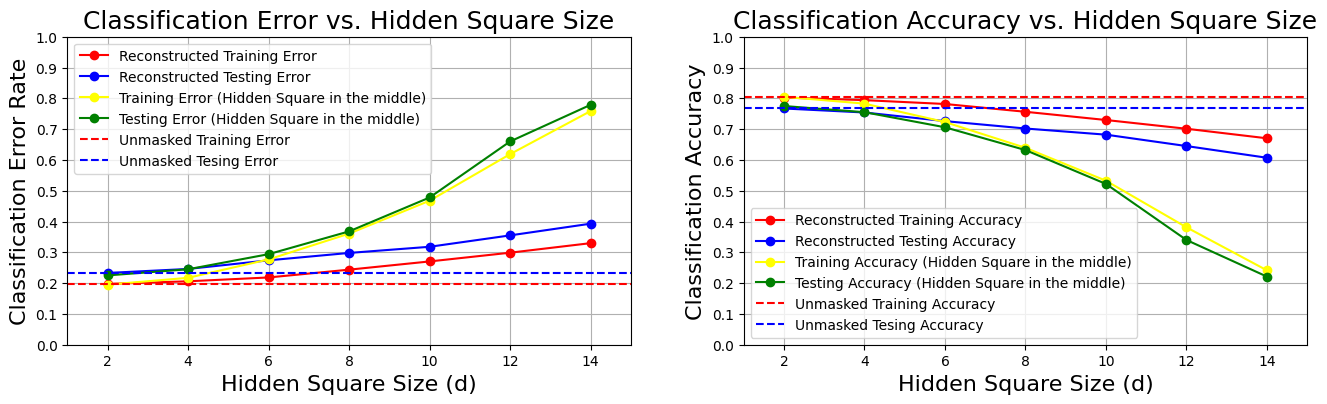

In [19]:
'''Plot classification performance of all'''

# Now plot the training and testing error vs d

# Set the figure size width and height
d_array = np.array([2, 4, 6, 8, 10, 12, 14])

# Set the figure size width and height
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(d_array, error_reconstructed_train_list, color='red', marker='o', label='Reconstructed Training Error')
axes[0].plot(d_array, error_reconstructed_test_list, color='blue', marker='o', label='Reconstructed Testing Error')
axes[0].plot(d_array, error_train_list, color='yellow', marker='o', label='Training Error (Hidden Square in the middle)')
axes[0].plot(d_array, error_test_list, color='green', marker='o', label='Testing Error (Hidden Square in the middle)')
axes[0].axhline(error_train_unmasked/n_train, color='red', linestyle='--', label='Unmasked Training Error')
axes[0].axhline(error_test_unmasked/n_test, color='blue', linestyle='--', label='Unmasked Tesing Error')

# Add labels
axes[0].set_xlabel('Hidden Square Size (d)', fontsize=16)
axes[0].set_ylabel('Classification Error Rate', fontsize=16)
axes[0].set_title('Classification Error vs. Hidden Square Size', fontsize=18)
axes[0].grid()

# Create a list of x-tick positions from 2 to 14 with a step of 2
xtick_positions = range(2, 15, 2)

# Now, set the x-ticks using the created list
axes[0].set_xticks(xtick_positions)

# Set the x-axis limits to 1 and 15
axes[0].set_xlim(1, 15)

# Create a list of y-tick positions from 0 to 1 with a step of 0.1
ytick_positions = [i/10 for i in range(11)]

# Now, set the y-ticks using the created list
axes[0].set_yticks(ytick_positions)

# Add a legend to the plot
axes[0].legend()

axes[1].plot(d_array, accuracy_reconstructed_train_list, color='red', marker='o', label='Reconstructed Training Accuracy')
axes[1].plot(d_array, accuracy_reconstructed_test_list, color='blue', marker='o', label='Reconstructed Testing Accuracy')
axes[1].plot(d_array, accuracy_train, color='yellow', marker='o', label='Training Accuracy (Hidden Square in the middle)')
axes[1].plot(d_array, accuracy_test, color='green', marker='o', label='Testing Accuracy (Hidden Square in the middle)')
axes[1].axhline(1-error_train_unmasked/n_train, color='red', linestyle='--', label='Unmasked Training Accuracy')
axes[1].axhline(1-error_test_unmasked/n_test, color='blue', linestyle='--', label='Unmasked Tesing Accuracy')

# Add labels
axes[1].set_xlabel('Hidden Square Size (d)', fontsize=16)
axes[1].set_ylabel('Classification Accuracy', fontsize=16)
axes[1].set_title('Classification Accuracy vs. Hidden Square Size', fontsize=18)
axes[1].grid()

# Create a list of x-tick positions from 2 to 14 with a step of 2
xtick_positions = range(2, 15, 2)

# Now, set the x-ticks using the created list
axes[1].set_xticks(xtick_positions)

# Set the x-axis limits to 1 and 15
axes[1].set_xlim(1, 15)

# Create a list of y-tick positions from 0 to 1 with a step of 0.1
ytick_positions = [i/10 for i in range(11)]

# Now, set the y-ticks using the created list
axes[1].set_yticks(ytick_positions)

# Add a legend to the plot
axes[1].legend()

# Display the plot
plt.show()